## Model data with RNN

In [168]:
print('hi')

hi


In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [170]:
df = pd.read_pickle('composite_df.pkl')
df['time_until_reading_hr'] = 24 - df['time_until_reading_hr']

# # assign group id numbers
df_g = df.groupby(['day_id', 'st_code'])
# df_grp = []
# j=0
# for i,grp in df_g:
#     a = grp.copy()
#     a['group_id'] = j
#     j += 1
#     df_grp.append(a)
# df = pd.concat(df_grp)

In [171]:
# just check that every thing is ordered
df[['st_code','day_id','gate_time','time_until_reading_hr']].head(30)

,st_code,day_id,gate_time,time_until_reading_hr
0,agp,13,2017-01-15 07:57:39,24.0
1,agp,13,2017-01-15 06:00:45,22.0
2,agp,13,2017-01-15 04:03:51,20.0
3,agp,13,2017-01-15 01:58:13,18.0
4,agp,13,2017-01-15 00:02:26,16.0
5,agp,14,2017-01-16 06:08:38,22.2
6,agp,14,2017-01-16 06:05:06,22.0
7,agp,14,2017-01-16 03:59:29,20.0
8,agp,14,2017-01-16 02:02:37,18.0
9,agp,14,2017-01-16 00:09:13,16.2


kill reflectivity data below 12 dB

In [172]:
# exp1 if cond else exp2
affected = ('refl_2000', 'refl_3000', 'refl_4000', 'refl_5000', 'refl_6000')
for col in affected:
    df[col].apply(lambda ref: 0 if ref < 12 else ref)


## augment data

In [173]:
df.shape

(9563, 31)

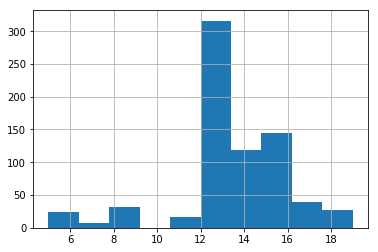

In [174]:
group_sizes = [len(g) for i,g in df_g]
pd.Series(group_sizes).hist()
plt.show()

In [175]:
# for each group, insert new rows randomly to reach max_seqlen
seqlen = max(group_sizes)

new_dfs = []
for i,a_group in df_g:
    indices = tuple(range(len(a_group)))
    new_indices = list(np.random.choice(indices, seqlen-len(a_group)))
    new_dfs.append(a_group.iloc[new_indices])

# combine all rows
aug_rows = pd.concat(new_dfs)
df = pd.concat([df, aug_rows])
del aug_rows

# sort
df = df.sort_values(['day_id','st_code', 'time_until_reading_hr'])
df.reset_index(inplace=True, drop=True)
df.fillna(0, inplace=True)

In [176]:
# assign group id numbers
df_g = df.groupby(['day_id', 'st_code'])
df_grp = []
j=0
for i,grp in df_g:
    a = grp.copy()
    a['seq_id'] = j
    j += 1
    df_grp.append(a)
df = pd.concat(df_grp)
df_g = df.groupby('seq_id')

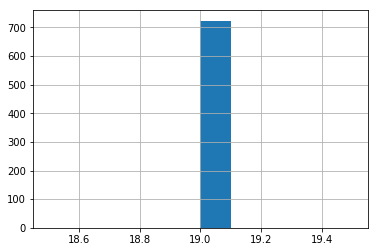

In [177]:
group_sizes = [len(g) for _,g in df_g]
pd.Series(group_sizes).hist()
plt.show()

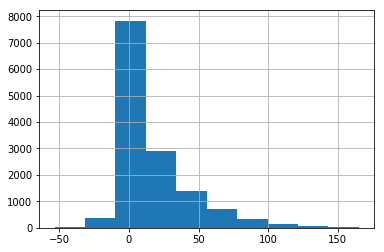

In [121]:
df['expected_mm'].hist(bins=10)
plt.show()

## Upsample data

In [122]:
print(df.expected_mm.max())
print(df.expected_mm.min())

165.1
-53.34


In [123]:
bucket_num = 5
bucket_num = (-50,-30, 0, 10, 30, 70, 160)
bucket_num = 8
df['bucket'] = pd.cut(df['expected_mm'], bins=bucket_num, labels=False)

temp_df = df[['bucket', 'seq_id', 'expected_mm']].drop_duplicates(subset='seq_id').reset_index(drop=True)
temp_df['bucket'] = pd.cut(temp_df['expected_mm'], bins=bucket_num, labels=False)
temp_df['bucket'].value_counts()

2    330
1    221
3    105
4     43
5     17
6      4
0      2
7      1
Name: bucket, dtype: int64

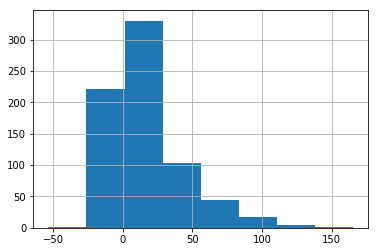

In [124]:
temp_df['expected_mm'].hist(bins=bucket_num)
plt.show()

In [125]:
max_count = temp_df['bucket'].value_counts().max()
counts = dict(temp_df['bucket'].value_counts())

In [126]:
# must upsample
# generate seq_id based upsample dataframe
from sklearn.utils import resample

upsamples = []
for c in counts:
    to_be_upsampled = temp_df[temp_df.bucket == c]
    #if counts[c] != max_count:
    to_be_upsampled = resample(to_be_upsampled, 
                             replace=True,     # sample with replacement
                             n_samples=max_count,    # to match majority class
                             random_state=123) 
    upsamples.append(to_be_upsampled)

temp_df_up = pd.concat(upsamples)
temp_df_up.sort_values("seq_id", inplace=True)
temp_df_up.reset_index(inplace=True, drop=True)
del upsamples

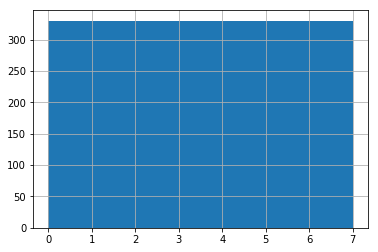

In [127]:
temp_df_up['bucket'].hist(bins=bucket_num)
plt.show()

In [128]:
%%time
# now apply apply temp_df_up to actual dataframe
upsamples = []
df_b = df.groupby('bucket')
for i, bucket_group in df_b:
    sequences = temp_df_up[temp_df_up['bucket'] == i]['seq_id']
    seq_list = []
    g_g = bucket_group.groupby('seq_id')
    for seq in sequences:
        seq_list.append(g_g.get_group(seq))
    upsamples.append(pd.concat(seq_list))
df_upsampled = pd.concat(upsamples)

CPU times: user 4.68 s, sys: 59.4 ms, total: 4.74 s
Wall time: 4.82 s


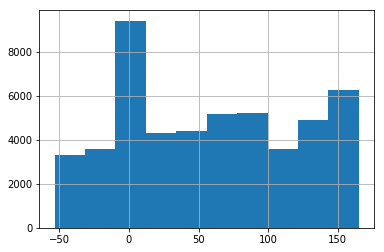

In [131]:
df_upsampled.expected_mm.hist()
plt.show()
# keras class weight

In [132]:
df = df_upsampled

## RNN model

### Setup inputs

In [178]:
# Check columns
df.columns



Index(['day_id', 'difphase_2000', 'difphase_3000', 'difphase_4000',
       'difphase_5000', 'difphase_6000', 'elev_m', 'expected_mm', 'gate_time',
       'lat', 'lon', 'r_dist_km', 'r_elev_delta_m', 'refl_2000', 'refl_3000',
       'refl_4000', 'refl_5000', 'refl_6000', 'st_code', 'time_until_reading',
       'time_until_reading_hr', 'velocity_2000', 'velocity_3000',
       'velocity_4000', 'velocity_5000', 'velocity_6000', 'xcorr_ratio_2000',
       'xcorr_ratio_3000', 'xcorr_ratio_4000', 'xcorr_ratio_5000',
       'xcorr_ratio_6000', 'seq_id'],
      dtype='object')

In [179]:

X = df.drop(['day_id','expected_mm', 'time_until_reading', 'gate_time', 'st_code', 'seq_id'], axis=1)
X.reset_index(inplace=True, drop=True)

y = df['expected_mm']

### 

def myround(x, base):
    return int(base * round(float(x)/base))

test_size = 0.3 # latter part

# round to seqlen to keep entire set of readings for each station
Xt_start = X.shape[0] - myround(X.shape[0]*test_size, seqlen)
Xt_end = X.shape[0]

###

X_train = X[:Xt_start]
X_test = X[Xt_start:]

y_train = np.array(y[:Xt_start])
y_test = np.array(y[Xt_start:])

# many-to-one problem, therefore y can be single values, not sequences of repeats
y_train = [y_train[i] for i in range(0, len(y_train), seqlen)]
y_test = [y_test[i] for i in range(0, len(y_test), seqlen)]



### Setup model

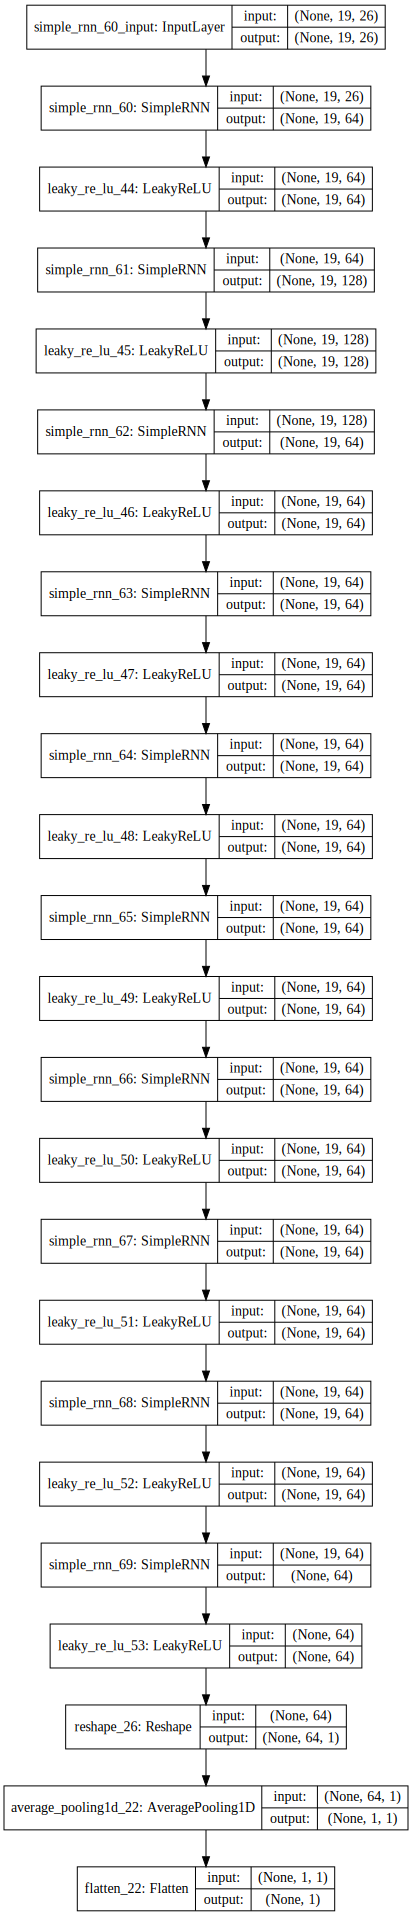

In [198]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Flatten, Reshape, AveragePooling1D, LSTM, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.advanced_activations import LeakyReLU
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

a = .01
# a = 0.001 # 13.26945
# a = 0.0005 # 14.09391
# a = 0.0015 # 14.70508
# input_features = 12 # 15.60
# input_features = 16 # 15.29
# input_features = 18 # 14.36
# input_features = 19 # 14.34
input_features = 16 # 13.24
# input_features = 21 # 16.23
# input_features = 22 # 13.74

col_num = X.shape[1]

model = Sequential()
# model.add(Dense(input_features, input_shape=(seqlen, col_num)))
# model.add(LeakyReLU(alpha=a))

model.add(SimpleRNN(64, return_sequences=True, input_shape=(seqlen, col_num)))
model.add(LeakyReLU(alpha=a))

model.add(SimpleRNN(128, return_sequences=True, input_shape=(seqlen, col_num)))
model.add(LeakyReLU(alpha=a))

model.add(SimpleRNN(64, return_sequences=True, input_shape=(seqlen, col_num)))
model.add(LeakyReLU(alpha=a))

model.add(SimpleRNN(64, return_sequences=True, input_shape=(seqlen, col_num)))
model.add(LeakyReLU(alpha=a))

model.add(SimpleRNN(64, return_sequences=True, input_shape=(seqlen, col_num)))
model.add(LeakyReLU(alpha=a))

model.add(SimpleRNN(64, return_sequences=True, input_shape=(seqlen, col_num)))
model.add(LeakyReLU(alpha=a))

model.add(SimpleRNN(64, return_sequences=True, input_shape=(seqlen, col_num)))
model.add(LeakyReLU(alpha=a))

model.add(SimpleRNN(64, return_sequences=True, input_shape=(seqlen, col_num)))
model.add(LeakyReLU(alpha=a))

model.add(SimpleRNN(64, return_sequences=True, input_shape=(seqlen, col_num)))
model.add(LeakyReLU(alpha=a))

model.add(SimpleRNN(64, return_sequences=False, input_shape=(seqlen, col_num)))
model.add(LeakyReLU(alpha=a))
# model.add(Bidirectional(SimpleRNN(64, return_sequences=False), input_shape=(seqlen, col_num)))
#model.add(LeakyReLU(alpha=a))
# model.add(Dense(64))

# model.add(Bidirectional(SimpleRNN(128, return_sequences=True)))
# model.add(LeakyReLU(alpha=a))
# model.add(Dense(128))

# model.add(Bidirectional(SimpleRNN(256, return_sequences=True)))
# model.add(LeakyReLU(alpha=a))
# model.add(Dense(256))

# model.add(Bidirectional(SimpleRNN(256, return_sequences=True)))
# model.add(LeakyReLU(alpha=a))
# model.add(Dense(256))

# model.add(Bidirectional(SimpleRNN(128, return_sequences=True)))
# model.add(LeakyReLU(alpha=a))
# model.add(Dense(128))

# model.add(Bidirectional(SimpleRNN(64, return_sequences=False)))
# model.add(LeakyReLU(alpha=a))
# model.add(Dense(64))

model.add(Reshape((64, 1)))
model.add(AveragePooling1D(pool_size=64))
model.add(Flatten())

model.compile(loss='mean_squared_error', optimizer='adadelta', metrics=['mse'])

#model.compile(loss='mean_absolute_error',optimizer='adadelta', metrics=['mae'])

#from keras.utils import plot_model
#plot_model(model, to_file='model.png')

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
#model.summary()




In [199]:
%%time
from keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 100
nseq_train = int(X_train.size/(seqlen*X_train.shape[1])) # number of sequences
nseq_test = int(X_test.size/(seqlen*X_test.shape[1])) # number of sequences

Xt = np.array(X_train).reshape(nseq_train, seqlen, col_num)
yt = np.array(y_train) # many-to-one prediction

Xtt = np.array(X_test).reshape(nseq_test, seqlen, col_num)
ytt = np.array(y_test)

# should setup loss history https://keras.io/callbacks/#example-model-checkpoints
#checkpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=1, save_best_only=True)
#model.fit(Xt, yt, epochs=epochs, validation_data=(Xtt, ytt), batch_size=64, callbacks=[checkpointer])

model.fit(
    # Feature matrix
    Xt,
    # Target class one-hot-encoded
    yt,
    # Iterations to be run if not stopped by EarlyStopping
    epochs=epochs,
    callbacks=[
        # Stop iterations when validation loss has not improved
        #EarlyStopping(monitor='val_loss', patience=25),
        # Nice for keeping the last model before overfitting occurs
        ModelCheckpoint(
            filepath='/tmp/weights.hdf5',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ],
    verbose=2,
    validation_data=(Xtt, ytt),
    batch_size=32,
)

# 15.78467
# 13.33083

Train on 506 samples, validate on 217 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 891.02405, saving model to /tmp/weights.hdf5
11s - loss: 984.7747 - mean_squared_error: 984.7747 - val_loss: 891.0240 - val_mean_squared_error: 891.0240
Epoch 2/100
Epoch 00001: val_loss improved from 891.02405 to 886.24742, saving model to /tmp/weights.hdf5
2s - loss: 977.1843 - mean_squared_error: 977.1843 - val_loss: 886.2474 - val_mean_squared_error: 886.2474
Epoch 3/100
Epoch 00002: val_loss improved from 886.24742 to 884.02682, saving model to /tmp/weights.hdf5
2s - loss: 974.7272 - mean_squared_error: 974.7272 - val_loss: 884.0268 - val_mean_squared_error: 884.0268
Epoch 4/100
Epoch 00003: val_loss improved from 884.02682 to 882.75611, saving model to /tmp/weights.hdf5
2s - loss: 972.9879 - mean_squared_error: 972.9879 - val_loss: 882.7561 - val_mean_squared_error: 882.7561
Epoch 5/100
Epoch 00004: val_loss improved from 882.75611 to 881.46035, saving model to /tmp/weights.hdf5
3

KeyboardInterrupt: 

Predict on all data

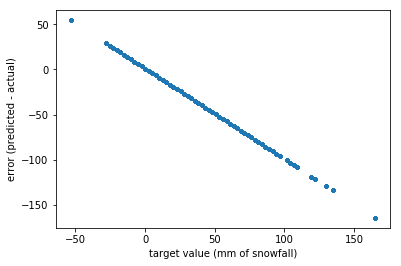

In [200]:
nseq_all = int(X.size/(seqlen*X.shape[1])) # number of sequences

model.load_weights('/tmp/weights.hdf5')

Xp = np.array(X).reshape(nseq_all, seqlen, col_num)
yp = np.array(y) # many-to-one prediction

ypp = model.predict(Xp).reshape(nseq_all)
ypp_repeats = [ypp[n//seqlen] for n in range(df.shape[0])]

df_final = df.copy()
df_final['predicted_mm'] = ypp_repeats
#df_final.to_pickle('rnn_results.pkl')

# plot residuals
plt.plot(df_final['expected_mm'], ypp_repeats-df_final['expected_mm'],'.')
plt.ylabel('error (predicted - actual)')
plt.xlabel('target value (mm of snowfall)')
plt.show()

In [11]:
# check if gpu being used. if GPU listed, it is automatically selected by keras

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7243329719748157374
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11332668621
locality {
  bus_id: 1
}
incarnation: 17006747767596690624
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"
]
